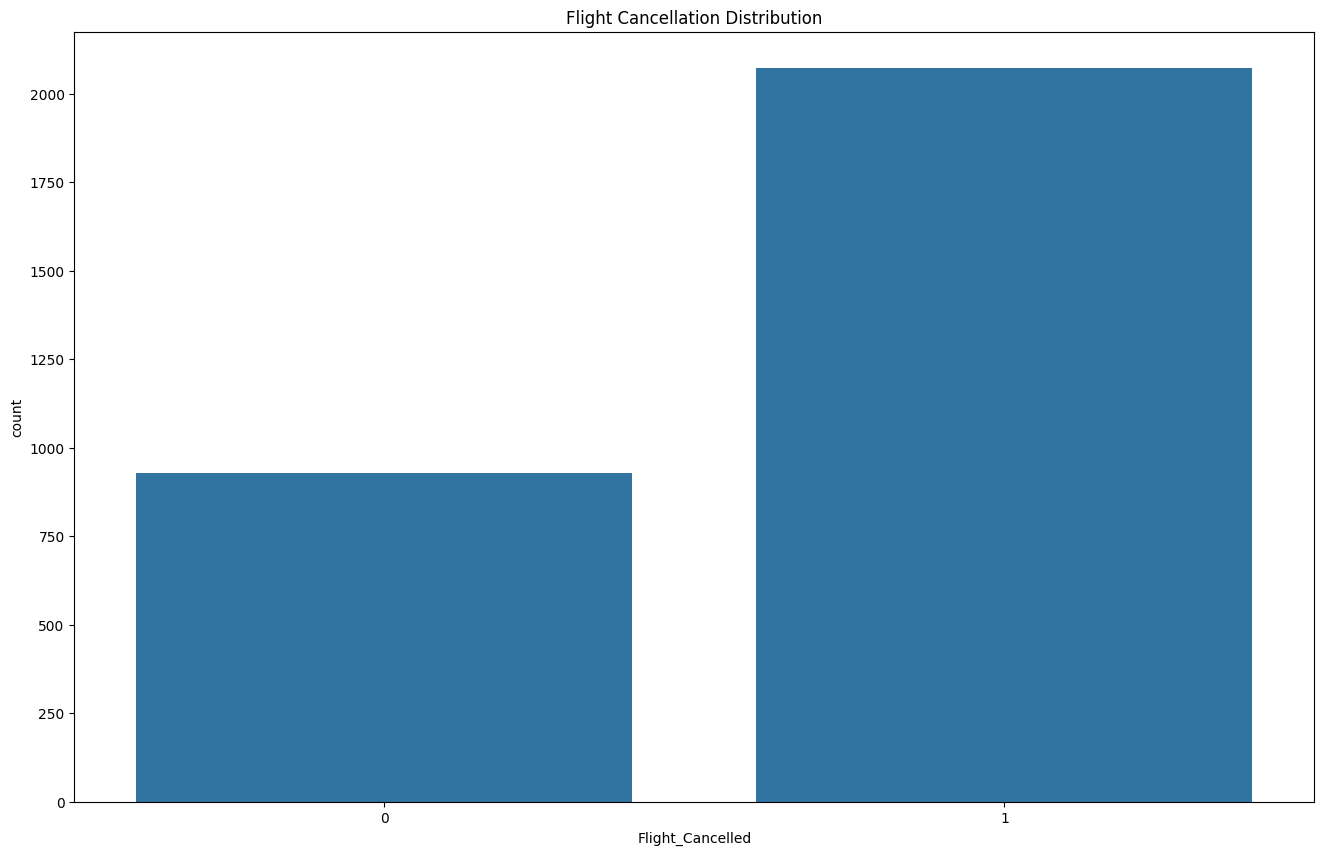

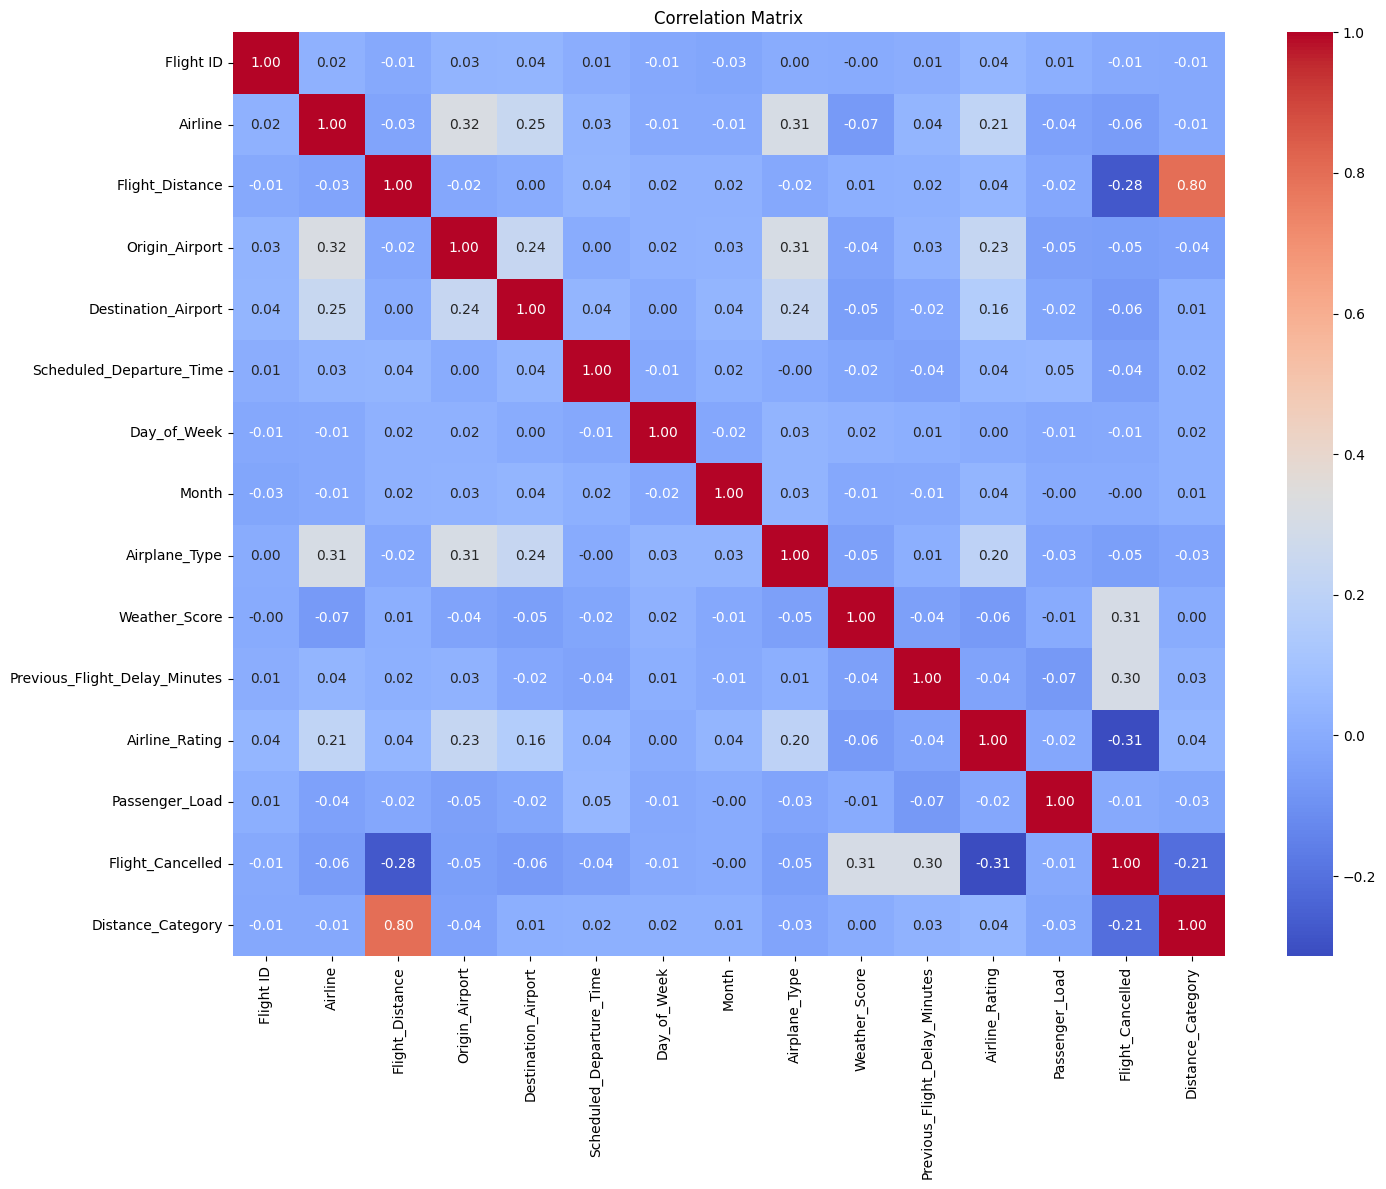

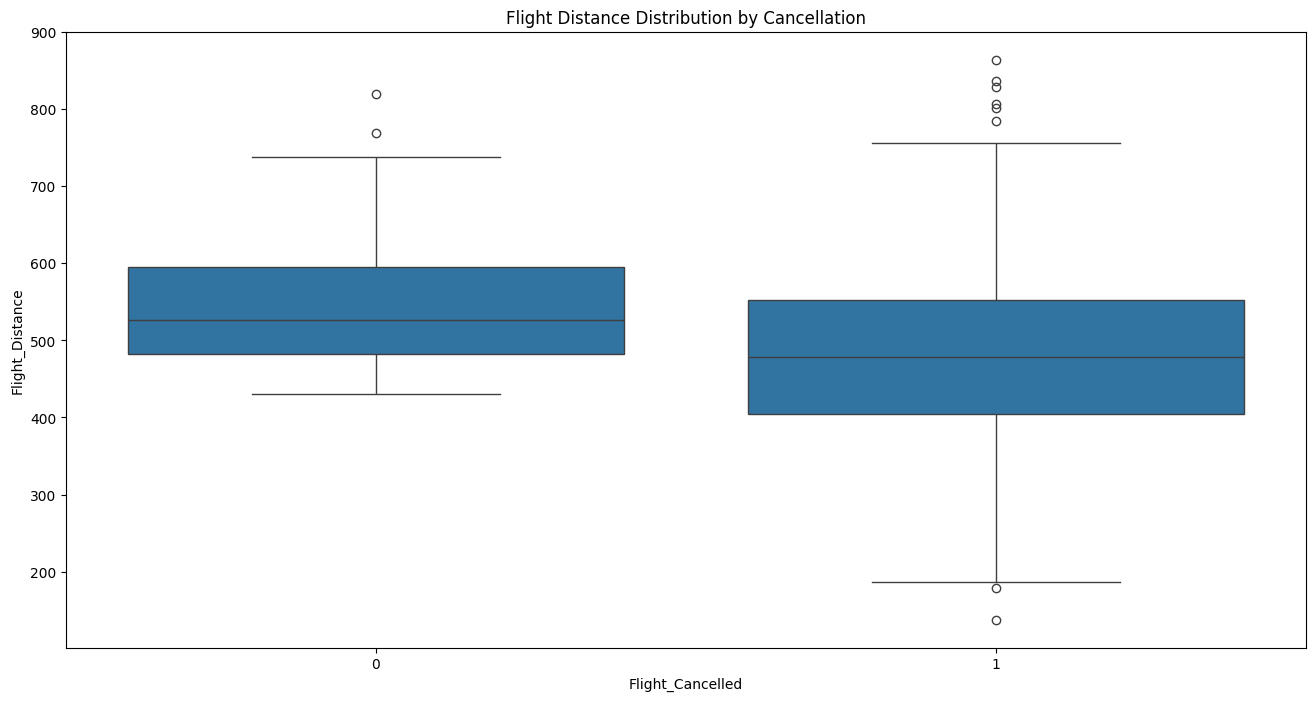

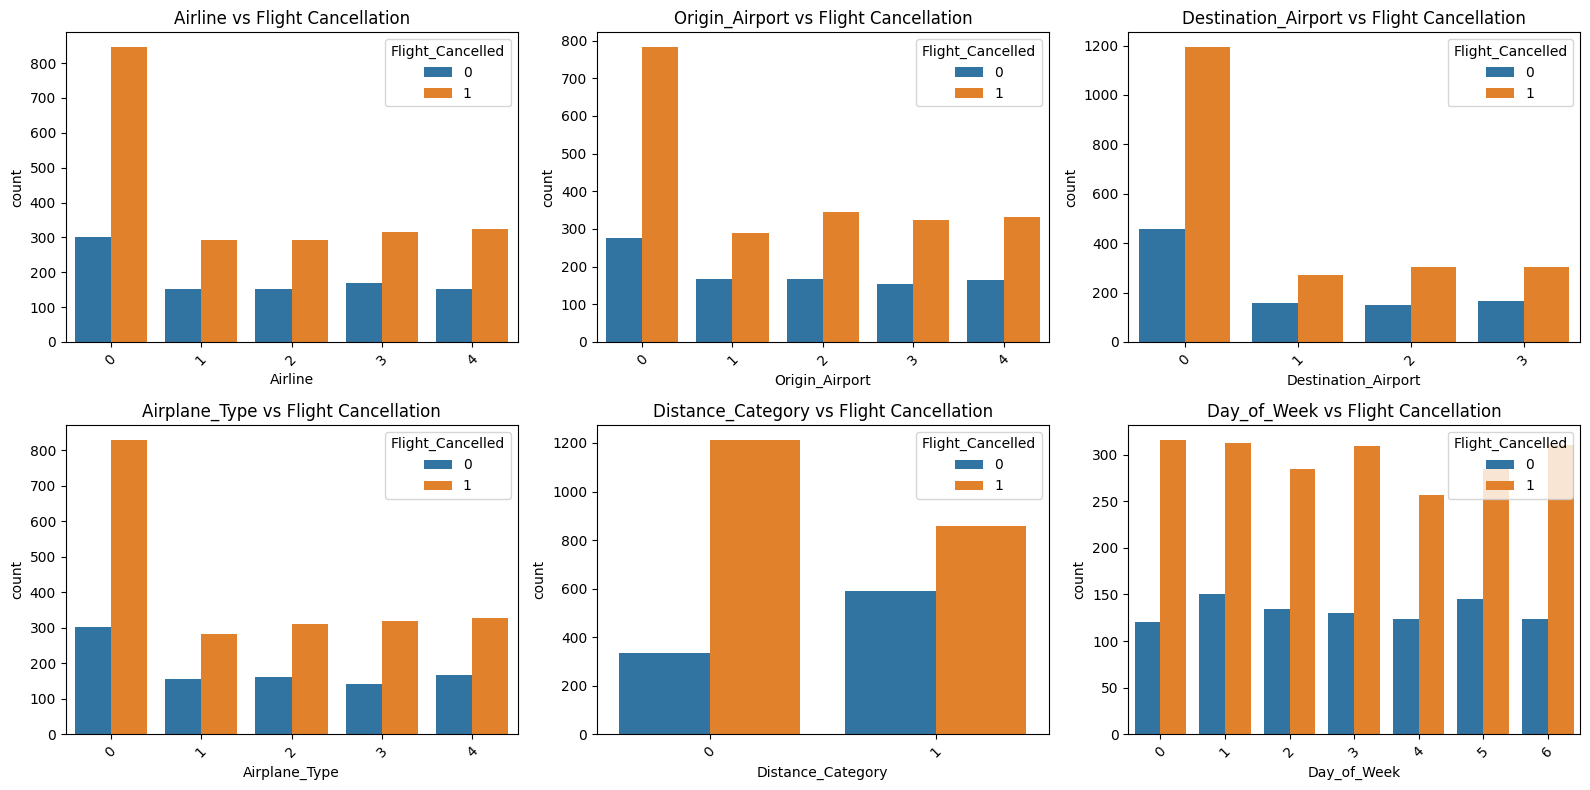

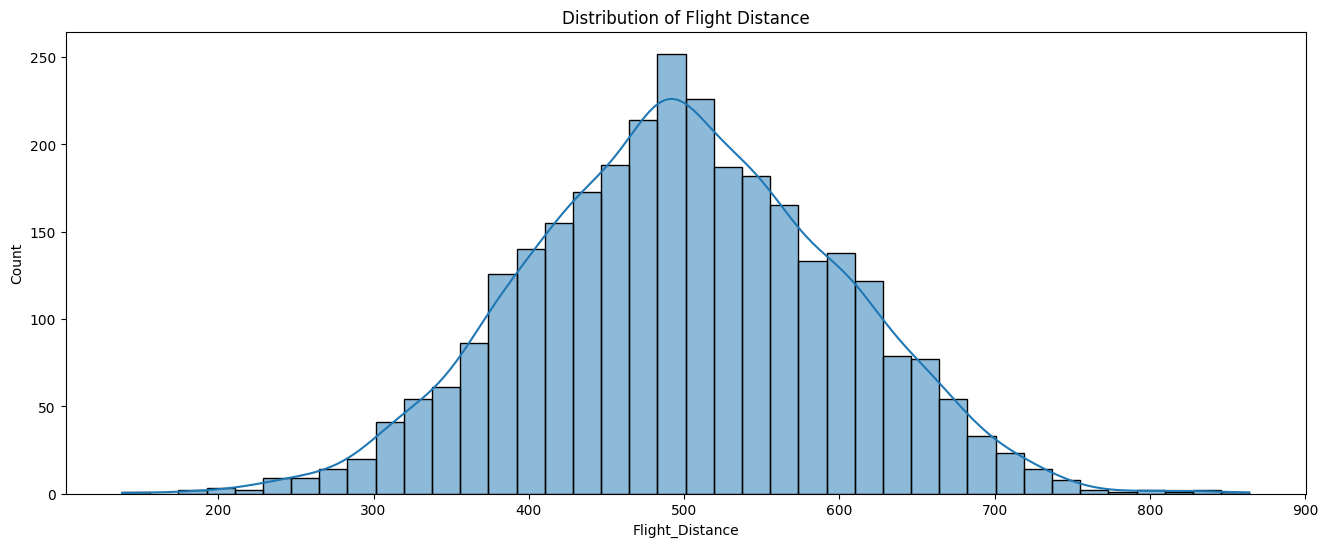

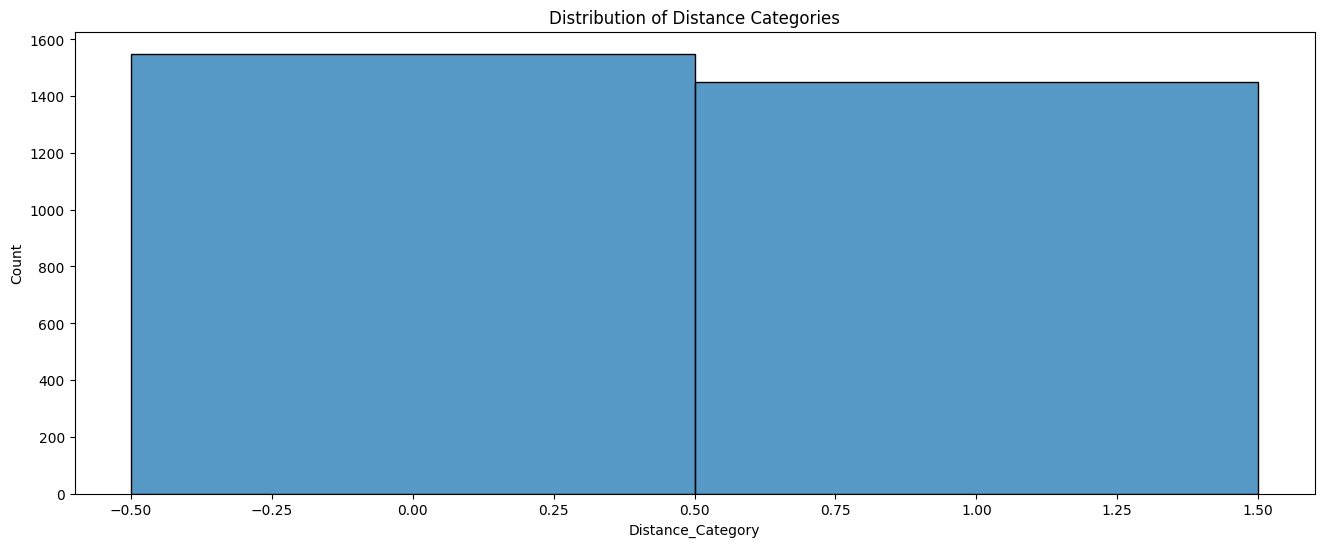

=== Logistic Regression ===
Accuracy : 0.8100
Precision: 0.8574
Recall   : 0.8698
F1 Score : 0.8635
ROC AUC  : 0.8798



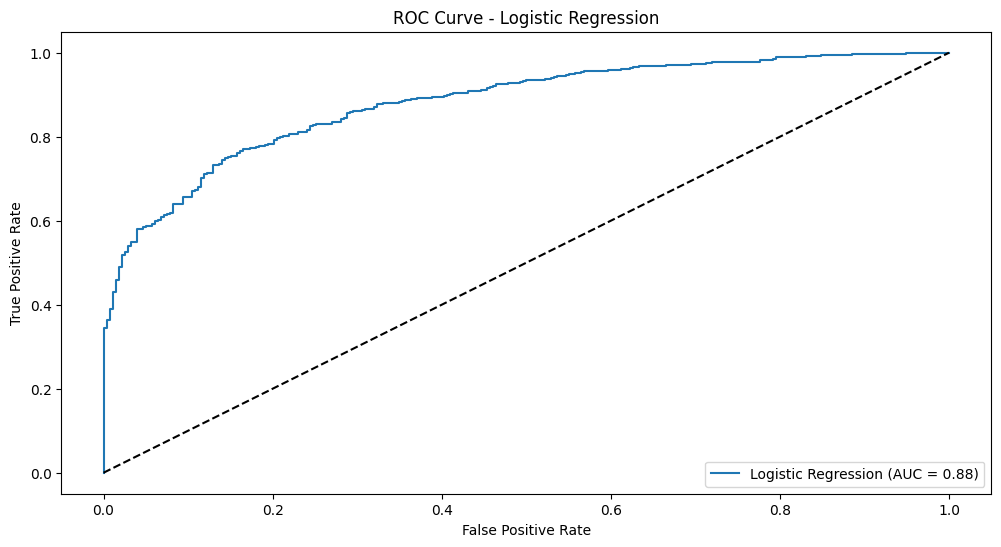

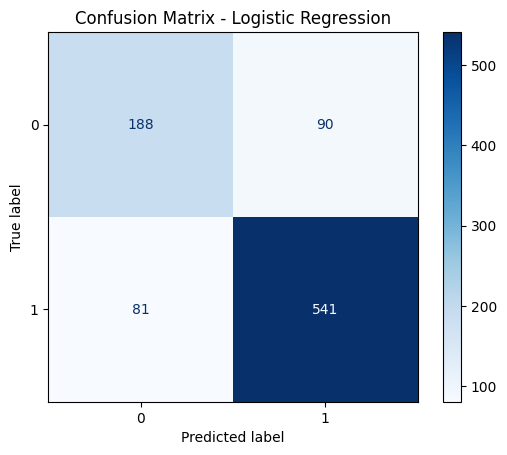

=== Random Forest ===
Accuracy : 0.9844
Precision: 0.9984
Recall   : 0.9791
F1 Score : 0.9886
ROC AUC  : 0.9904



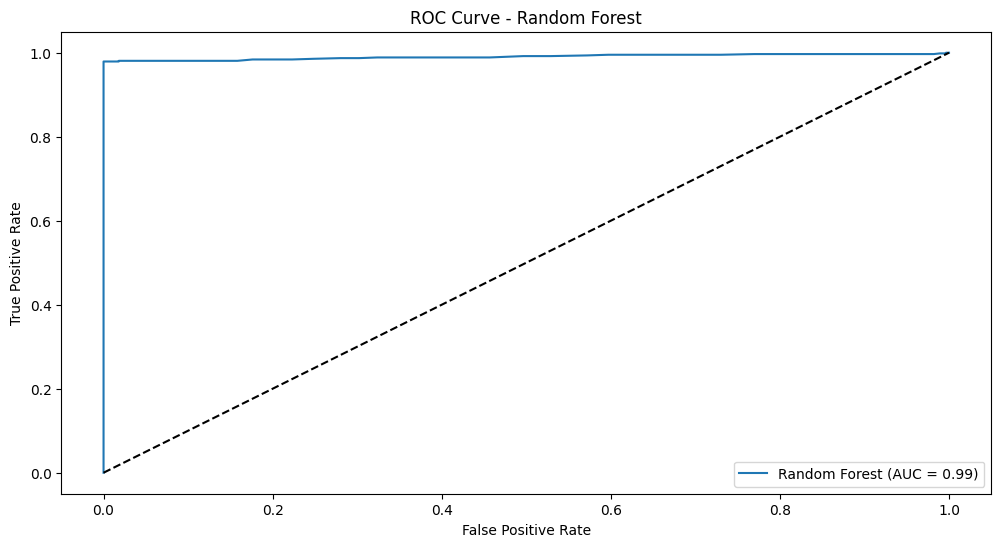

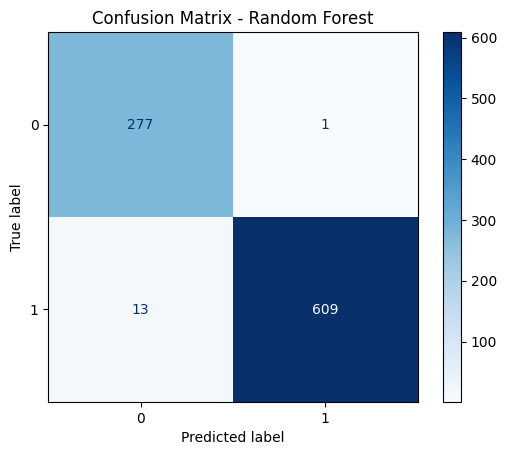

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
Accuracy : 0.9822
Precision: 0.9967
Recall   : 0.9775
F1 Score : 0.9870
ROC AUC  : 0.9880



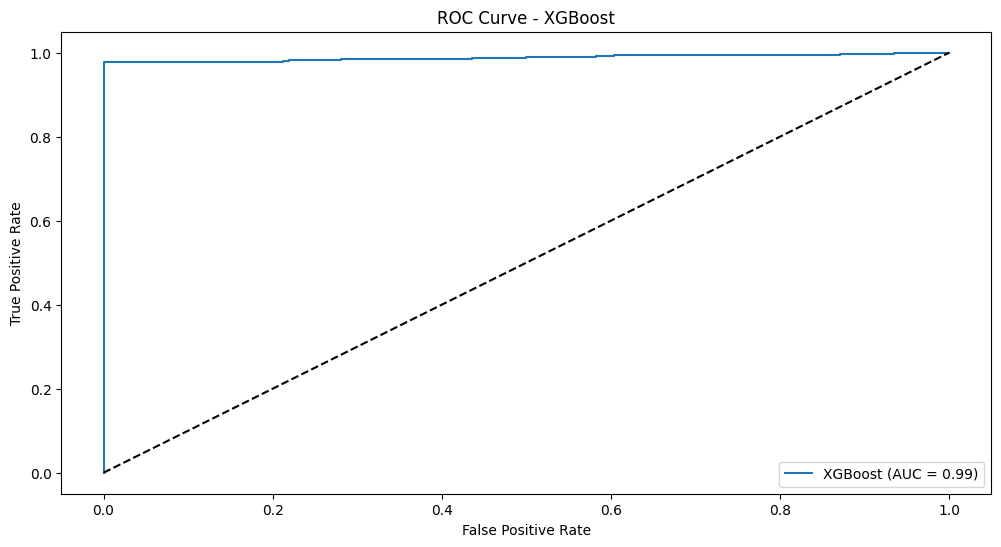

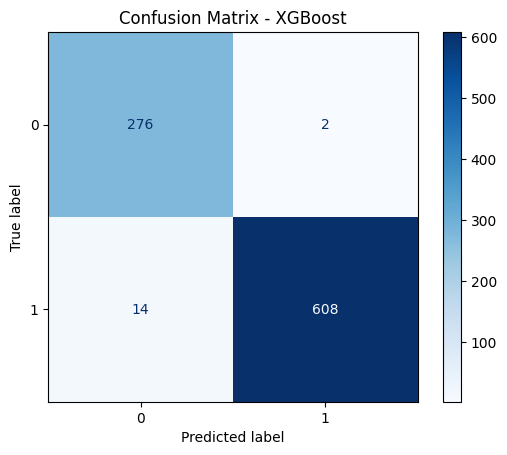

Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.810000   0.857369  0.869775  0.863528  0.879838
1        Random Forest  0.984444   0.998361  0.979100  0.988636  0.990377
2              XGBoost  0.982222   0.996721  0.977492  0.987013  0.988023


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

df = pd.read_csv('flight_data.csv')

bins = [0, 500, 1500, np.inf]
labels = [0, 1, 2]
df['Distance_Category'] = pd.cut(df['Flight_Distance'], bins=bins, labels=labels)

if 'Flight_Date' in df.columns:
    df['Flight_Date'] = pd.to_datetime(df['Flight_Date'])
    df['Day_of_Week'] = df['Flight_Date'].dt.dayofweek

categorical_features = ['Airline', 'Origin_Airport', 'Destination_Airport', 'Airplane_Type', 'Distance_Category']
if 'Day_of_Week' in df.columns:
    categorical_features.append('Day_of_Week')

le = LabelEncoder()
for col in categorical_features:
    df[col] = le.fit_transform(df[col].astype(str))

columns_to_drop = ['Flight_Cancelled']
if 'Flight_ID' in df.columns:
    columns_to_drop.append('Flight_ID')
if 'Flight_Date' in df.columns:
    columns_to_drop.append('Flight_Date')

X = df.drop(columns=columns_to_drop)
y = df['Flight_Cancelled']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []

plt.figure(figsize=(16, 10))
sns.countplot(x='Flight_Cancelled', data=df)
plt.title("Flight Cancellation Distribution")
plt.show()

plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

plt.figure(figsize=(16, 8))
sns.boxplot(x='Flight_Cancelled', y='Flight_Distance', data=df)
plt.title("Flight Distance Distribution by Cancellation")
plt.show()

plt.figure(figsize=(16, 8))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    sns.countplot(x=col, hue='Flight_Cancelled', data=df)
    plt.xticks(rotation=45)
    plt.title(f'{col} vs Flight Cancellation')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
sns.histplot(df['Flight_Distance'], bins=40, kde=True)
plt.title('Distribution of Flight Distance')
plt.show()

plt.figure(figsize=(16, 6))
sns.histplot(df['Distance_Category'], bins=3, discrete=True)
plt.title('Distribution of Distance Categories')
plt.show()

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

    print(f"=== {name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

results_df = pd.DataFrame(results)
print("Model Performance Summary:")
print(results_df)

df.to_csv('yourname_feature_engineered_data.csv', index=False)
results_df.to_csv('yourname_model_performance_comparison.csv', index=False)
